In [10]:
import pickle
import string
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy, multivariate_normal
from sklearn import metrics
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")

sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)


def truncate(n, dicimals=2):
    return round(n, dicimals)


# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return ">"
    elif A < B:
        return "<"
    else:
        return "="

In [2]:
# For generating Variable C
def generate_gauss_mix(
    N=5000,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1=1,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=None,
    split_class1=None,
):
    class0_mix = True if split_class0 is not None else False
    class1_mix = True if split_class1 is not None else False

    prior_0, prior_1 = prior
    p_class0, p_class1 = prior
    n0 = int(N * prior_0)  # number of samples from class 0
    n1 = N - n0  # total number of samples from class 1

    if class1_mix:
        p_class0, p_class1_0, p_class1_1 = (
            prior_0,
            prior_1 * split_class1[0],
            prior_1 * split_class1[1],
        )
        n0 = int(N * p_class0)  # number of samples from class 0
        n1 = N - n0  # total number of samples from class 1
        n1_0 = int(N * p_class1_0)  # number of samples from class 1_0
        n1_1 = n1 - n1_0  # number of samples from class 1_1
        mu_class1_0 = np.array([mu_class1_0] * p)
        mu_class1_1 = np.array([mu_class1_1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1_0 = np.identity(p) * sig_class1_0
        sig_class1_1 = np.identity(p) * sig_class1_1
        x_1_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
        x_1_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
        x_1 = np.vstack((x_1_0, x_1_1))
    else:
        # p_class0, p_class1 = prior
        mu_class1 = np.array([mu_class1] * p)
        sig_class0 = np.identity(p) * sig_class0
        sig_class1 = np.identity(p) * sig_class1
        x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    if class0_mix:
        p_class0_0, p_class0_1 = split_class0
        n0 = int(N * p_class0)
        n0_0 = int(n0 * p_class0_0)
        n0_1 = n0 - n0_0
        mu_class0_0 = np.array([mu_class0_0] * p)
        mu_class0_1 = np.array([mu_class0_1] * p)
        sig_class0_0 = np.identity(p) * sig_class0_0
        sig_class0_1 = np.identity(p) * sig_class0_1
        x_0_0 = np.random.multivariate_normal(mu_class0_0, sig_class0_0, size=n0_0)
        x_0_1 = np.random.multivariate_normal(mu_class0_1, sig_class0_1, size=n0_1)
        x_0 = np.vstack((x_0_0, x_0_1))
    else:
        mu_class0 = np.array([mu_class0] * p)
        x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)

    x = np.vstack((x_0, x_1))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    # Create the probability density functions (PDFs) for the two Gaussian distributions
    if class0_mix:
        pdf_class0_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class0_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class0_0 = pdf_class0_0.pdf(x)
        p_x_given_class0_1 = pdf_class0_1.pdf(x)
        p_x_given_class0 = (
            split_class1[0] * p_x_given_class0_0 + split_class0[1] * p_x_given_class0_1
        )
    else:
        pdf_class0 = multivariate_normal(mu_class0, sig_class0)
        p_x_given_class0 = pdf_class0.pdf(x)

    if class1_mix:
        pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
        pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
        p_x_given_class1_0 = pdf_class1_0.pdf(x)
        p_x_given_class1_1 = pdf_class1_1.pdf(x)
        p_x_given_class1 = (
            split_class1[0] * p_x_given_class1_0 + split_class1[1] * p_x_given_class1_1
        )
    else:
        pdf_class1 = multivariate_normal(mu_class1, sig_class1)
        p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1

    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * (1 - p_class0) / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))

    # if class0_mix:
    #     prior_y_0 = np.array([p_class0_0, p_class0_1])
    # else:
    #     prior_y_0 = np.array(p_class0)

    # if class1_mix:
    #     prior_y_1 = np.array([p_class1_0, p_class1_1])
    # else:
    #     prior_y_1 = np.array(p_class1)

    entropy_y = entropy(prior, base=np.exp(1))
    correlation = np.corrcoef(x_0.T, x_1.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    if MI == 0.0:
        # replace the posterior with random numbers ~ U(0,1) to calculate the ROC curve
        posterior_ = np.random.uniform(0, 1, size=(N, 2))
        fpr, tpr, thresholds = metrics.roc_curve(
            y, posterior_[:, 1], pos_label=1, drop_intermediate=False
        )
    else:
        fpr, tpr, thresholds = metrics.roc_curve(
            y, posterior[:, 1], pos_label=1, drop_intermediate=False
        )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)

    statistics = {
        # 'Correlation': correlation[0,1],
        "Accuracy": accuracy,
        # "F1": f1,
        "MI": MI,
        "AUC": auc,
        # "pAUC_90": pauc_90,
        # "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'Sensitivity': sensitivity,
        # 'Specificity': specificity,
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
        # "tpr": tpr,
        # "fpr": fpr,
    }
    x_min, x_max = np.min(x), np.max(x)
    # print(x_min, x_max)
    xs = np.linspace(x_min - 1, x_max + 1, 1000)
    pdf = pd.DataFrame()
    pdf["x"] = xs
    if class0_mix:
        pdf["pdf_class0"] = split_class0[0] * pdf_class0_0.pdf(xs) + split_class0[
            1
        ] * pdf_class0_1.pdf(xs)
    else:
        pdf["pdf_class0"] = pdf_class0.pdf(xs)
    if class1_mix:
        pdf["pdf_class1"] = split_class1[0] * pdf_class1_0.pdf(xs) + split_class1[
            1
        ] * pdf_class1_1.pdf(xs)
    else:
        pdf["pdf_class1"] = pdf_class1.pdf(xs)

    return x, y, posterior[:, 1], statistics, pdf

In [3]:
N = 50000
x_A, y_A, posterior_A, statistics_A, pdf_A = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1=1,
    sig_class0=1,
    sig_class1=1,
    split_class1=None,
)

In [4]:
# Generate the data
x_B, y_B, posterior_B, statistics_B, pdf_B = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0=0,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class1=(0.75, 0.25),
)

In [5]:
# Generate the data
x_C, y_C, posterior_C, statistics_C, pdf_C = generate_gauss_mix(
    N=N,
    prior=(0.5, 0.5),
    p=1,
    mu_class0_0=0,
    mu_class0_1=5,
    mu_class1_0=0,
    mu_class1_1=5,
    sig_class0_0=1,
    sig_class0_1=1,
    sig_class1_0=1,
    sig_class1_1=1,
    split_class0=(0.75, 0.25),
    split_class1=(0.75, 0.25),
)

In [6]:
def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)
    rng1 = np.random.default_rng(seed=seed)
    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])
    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)
    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")
    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"
    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng1.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X_mixture_2 = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                X_mixture.reshape(n_samples // 2, n_informative),
                X_mixture_2.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng1.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(f"Simulation must be: trunk, trunk_overlap, trunk_mix")
    if n_dim > n_informative:
        X = np.hstack(
            (X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative)))
        )
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [7]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba


def make_simulation(name="linear", seed=23, sample_size=256):
    if name == "linear":
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk",
            n_informative=1,
            seed=seed,
        )
    elif name == "nonlinear":
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk_mix",
            mu_0=0,
            mu_1=5,
            mix=0.75,
            n_informative=1,
            seed=seed,
        )
    else:
        X, y = make_trunk_classification(
            n_samples=sample_size,
            n_dim=4096,
            simulation="trunk_overlap",
            mu_0=0,
            mu_1=5,
            mix=0.75,
            n_informative=1,
            seed=seed,
        )

    #     train_samples = 256  # Samples used for training the models
    #     X_train, X_test, y_train, y_test = train_test_split(
    #         X,
    #         y,
    #         shuffle=True,
    #         stratify=y,
    #         test_size=100000 - train_samples,
    #     )

    #     lr = LogisticRegressionCV(
    #         Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
    #     )
    lr = LogisticRegression(
        penalty="l1", solver="liblinear", n_jobs=n_jobs, random_state=seed
    )
    gnb = GaussianNB()
    #     svc = NaivelyCalibratedLinearSVC(C=1.0)
    svc = SVC(probability=True, kernel="rbf", random_state=seed)
    rfc = RandomForestClassifier(
        n_estimators=6000, max_features=0.3, n_jobs=n_jobs, random_state=seed
    )
    might = HonestForestClassifier(
        n_estimators=6000,
        max_samples=1.6,
        max_features=0.3,
        bootstrap=True,
        stratify=True,
        random_state=seed,
        n_jobs=n_jobs,
    )

    clf_list = [
        (might, "MIGHT"),
        (rfc, "Random Forest"),
        (svc, "SVM"),
        (gnb, "Naive Bayes"),
        (lr, "Logistic Regression"),
    ]

    fpr_s = []
    tpr_s = []
    for i, (clf, name) in enumerate(clf_list):
        if name == "MIGHT":
            _, observe_proba = build_hyppo_oob_forest(clf, X, y)
            observe_proba = np.nanmean(observe_proba, axis=0)
            fpr, tpr, thresholds = roc_curve(
                y, observe_proba[:, 1], pos_label=1, drop_intermediate=False
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, stratify=y, test_size=0.2
            )

            X_fit, X_cal, y_fit, y_cal = train_test_split(
                X_train, y_train, test_size=0.5, stratify=y_train
            )
            clf.fit(X_fit, X_fit)

            calibrated_model = CalibratedClassifierCV(
                clf, cv="prefit", method="isotonic"
            )
            calibrated_model.fit(X_cal, y_cal)
            posterior = calibrated_model.predict_proba(X_val)

            fpr, tpr, thresholds = roc_curve(
                y_test,
                posterior(X_test)[:, 1],
                pos_label=1,
                drop_intermediate=False,
            )
        fpr_s.append(fpr)
        tpr_s.append(tpr)

    return clf_list, fpr_s, tpr_s

In [8]:
clf_name = [
    "MIGHT",
    "Random Forest",
    "SVM",
    "Naive Bayes",
    "Logistic Regression",
]

In [10]:
clf_linear_s = []
fpr_linear_s = []
tpr_linear_s = []
N_ITR = 10

for i in range(N_ITR):
    #     print(i)
    clf_linear, fpr_linear, tpr_linear = make_simulation("linear", seed=i)
    clf_linear_s.append(clf_linear)
    fpr_linear_s.append(fpr_linear)
    tpr_linear_s.append(tpr_linear)

    #     print("non")
    clf_nonlinear, fpr_nonlinear, tpr_nonlinear = make_simulation("nonlinear", seed=i)
    clf_nonlinear_s.append(clf_nonlinear)
    fpr_nonlinear_s.append(fpr_nonlinear)
    tpr_nonlinear_s.append(tpr_nonlinear)

    #     print("null")
    clf_null, fpr_null, tpr_null = make_simulation("null", seed=i)
    clf_null_s.append(clf_null)
    fpr_null_s.append(fpr_null)
    tpr_null_s.append(tpr_null)

    with open(DIRECTORY + "fpr_linear.pkl", "wb") as f:
        pickle.dump(fpr_linear, f)

    with open(DIRECTORY + "tpr_linear.pkl", "wb") as f:
        pickle.dump(tpr_linear, f)

    with open(DIRECTORY + "fpr_nonlinear.pkl", "wb") as f:
        pickle.dump(fpr_nonlinear, f)

    with open(DIRECTORY + "tpr_nonlinear.pkl", "wb") as f:
        pickle.dump(tpr_nonlinear, f)

    with open(DIRECTORY + "fpr_null.pkl", "wb") as f:
        pickle.dump(fpr_null, f)

    with open(DIRECTORY + "tpr_null.pkl", "wb") as f:
        pickle.dump(tpr_null, f)

In [131]:
DIRECTORY = "fig1_pkl_v6/held-out/one_h/"
SAMPLE = 256

with open(DIRECTORY + "fpr_linear_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_linear_s = pickle.load(f)

with open(DIRECTORY + "tpr_linear_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_linear_s = pickle.load(f)

with open(DIRECTORY + "fpr_nonlinear_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_nonlinear_s = pickle.load(f)

with open(DIRECTORY + "tpr_nonlinear_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_nonlinear_s = pickle.load(f)

with open(DIRECTORY + "fpr_null_" + str(SAMPLE) + ".pkl", "rb") as f:
    fpr_null_s = pickle.load(f)

with open(DIRECTORY + "tpr_null_" + str(SAMPLE) + ".pkl", "rb") as f:
    tpr_null_s = pickle.load(f)

In [132]:
base_fpr = np.linspace(0, 1, 1001)
N_ITR = 10

linear_s = []
nonlinear_s = []
null_s = []
for j in range(1):
    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_linear_s[i][j], tpr_linear_s[i][j])
        tpr_s.append(tpr)

    tpr_s = np.mean(tpr_s, axis=0)
    linear_s.append(tpr_s)

    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_nonlinear_s[i][j], tpr_nonlinear_s[i][j])
        tpr_s.append(tpr)

    tpr_s = np.mean(tpr_s, axis=0)
    nonlinear_s.append(tpr_s)

    tpr_s = []
    for i in range(N_ITR):
        tpr = np.interp(base_fpr, fpr_null_s[i][j], tpr_null_s[i][j])
        tpr_s.append(tpr)

    tpr_s = np.mean(tpr_s, axis=0)
    null_s.append(tpr_s)

In [39]:
# X, y = make_trunk_classification(
#     n_samples=sample_size,
#     n_dim=4096,
#     simulation="trunk",
#     n_informative=1,
#     seed=seed,
# )
# X, y = make_trunk_classification(
#     n_samples=256,
#     n_dim=4096,
#     simulation="trunk_mix",
#     mu_0=0,
#     mu_1=5,
#     mix=0.75,
#     n_informative=1,
#     seed=1,
# )
X, y = make_trunk_classification(
    n_samples=256,
    n_dim=4096,
    simulation="trunk_overlap",
    mu_0=0,
    mu_1=5,
    mix=0.75,
    n_informative=1,
    seed=1,
)

In [87]:
from sktree.tree import HonestTreeClassifier

fpr_ls = []
tpr_ls = []
proba_ls = []
for i in range(10):
    print(i)
    X, y = make_trunk_classification(
        n_samples=256,
        n_dim=4096,
        simulation="trunk_overlap",
        mu_0=0,
        mu_1=5,
        mix=0.75,
        n_informative=1,
        seed=i,
    )

    #     might_1 = HonestForestClassifier(
    #         n_estimators=6000,
    #         max_samples=1.6,
    #         max_features=0.3,
    #         bootstrap=True,
    #         stratify=True,
    #         random_state=i+23,
    #         n_jobs=-2,
    #     )

    might_1 = HonestTreeClassifier(stratify=True, random_state=i)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, stratify=y, test_size=0.2
    )
    might_1.fit(X_train, y_train)
    observe_proba = might_1.predict_proba(X_test)
    #     _, observe_proba = build_hyppo_oob_forest(might_1, X, y)
    #     observe_proba = np.nanmean(observe_proba, axis=0)

    fpr, tpr, thresholds = roc_curve(
        y_test, observe_proba[:, 1], pos_label=1, drop_intermediate=False
    )
    fpr_ls.append(fpr)
    tpr_ls.append(tpr)
    proba_ls.append(observe_proba)

0
1
2
3
4
5
6
7
8
9


single tree


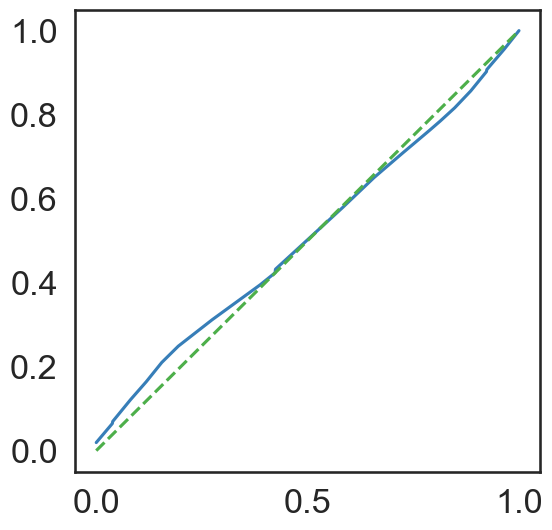

In [89]:
base_fpr = np.linspace(0, 1, 1001)
N_ITR = 10
tpr_s = []
for i in range(N_ITR):
    tpr = np.interp(base_fpr, fpr_ls[i], tpr_ls[i])
    tpr_s.append(tpr)

tpr_s = np.mean(tpr_s, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(base_fpr, tpr_s)
ax.plot([0, 1], [0, 1], "--")
print("single tree")

100 trees


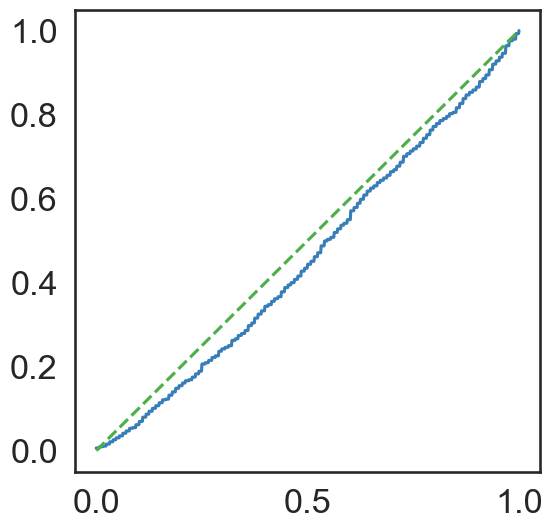

In [51]:
base_fpr = np.linspace(0, 1, 1001)
N_ITR = 10
tpr_s = []
for i in range(N_ITR):
    tpr = np.interp(base_fpr, fpr_ls[i], tpr_ls[i])
    tpr_s.append(tpr)

tpr_s = np.mean(tpr_s, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(base_fpr, tpr_s)
ax.plot([0, 1], [0, 1], "--")
print("100 trees")

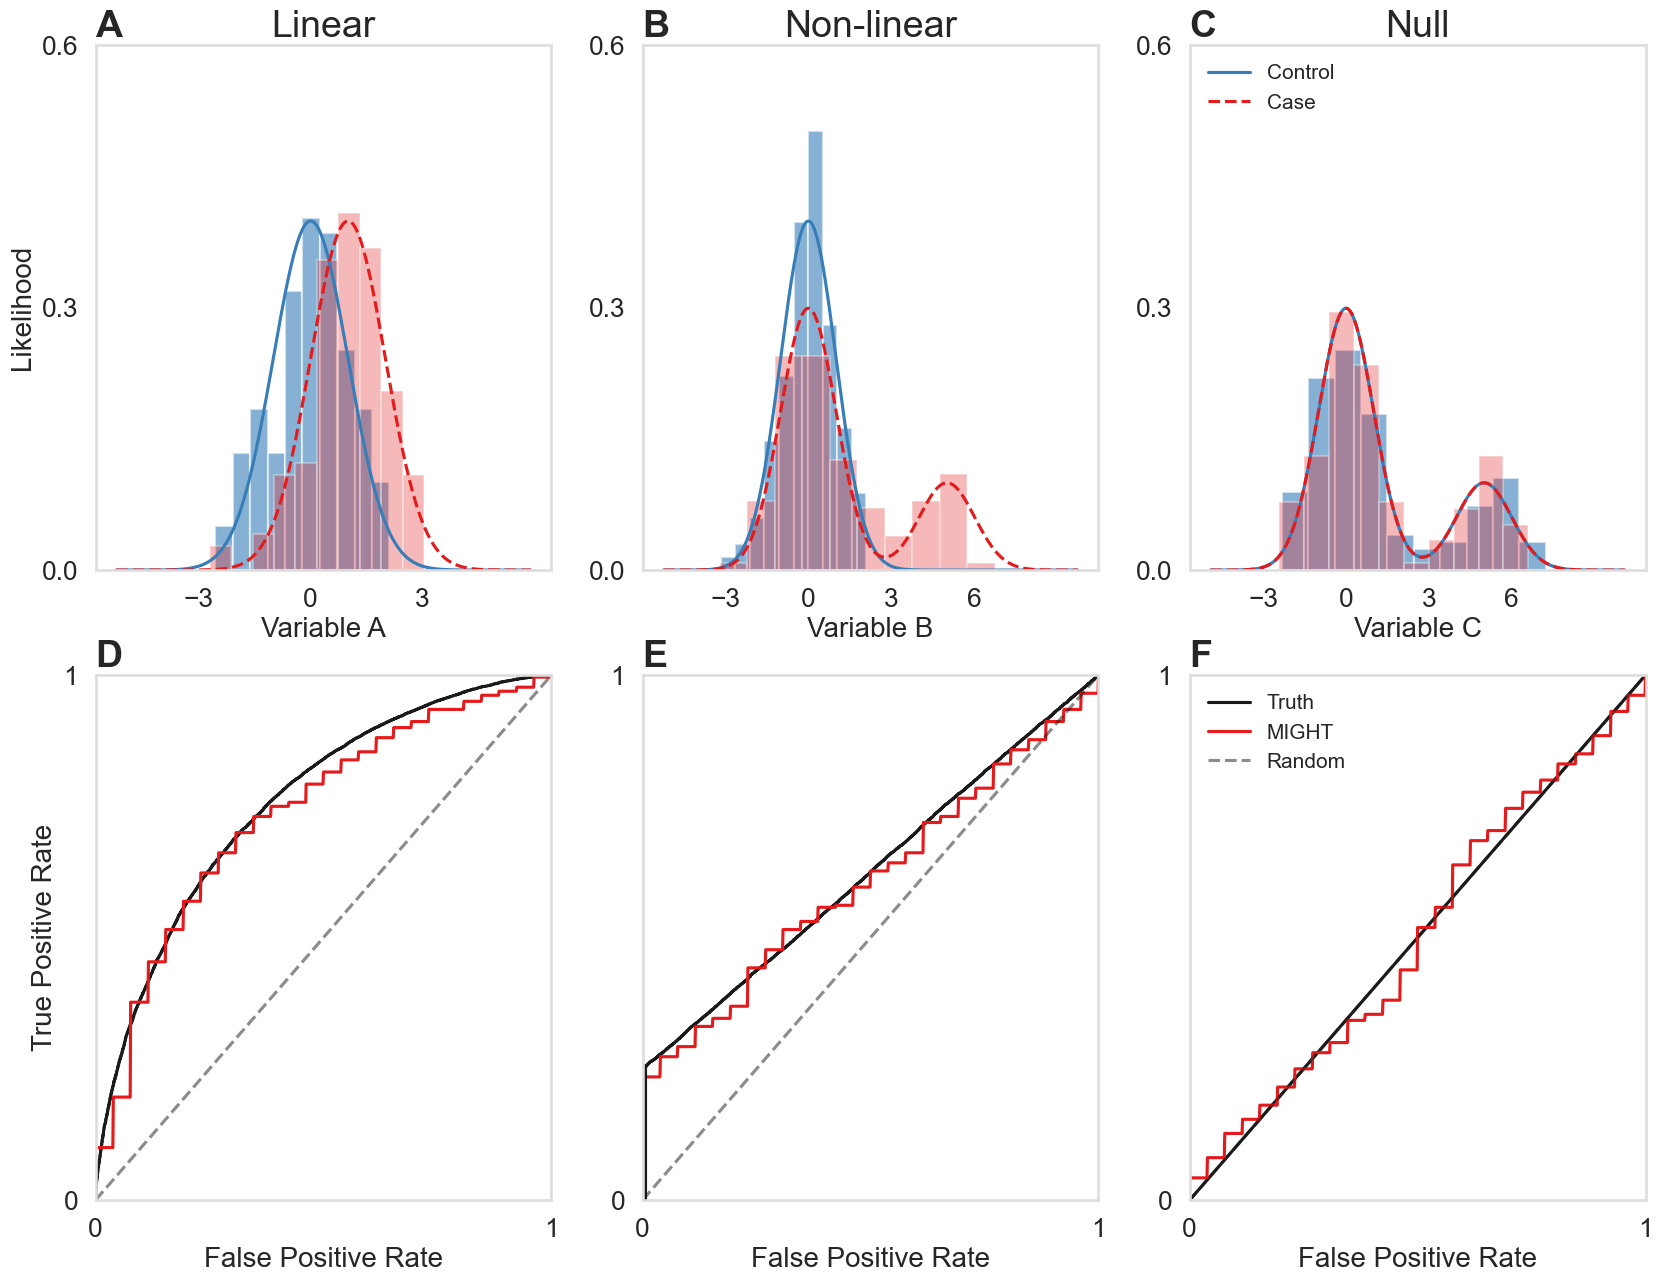

In [133]:
# plot the data
fontsize = 15
tablefontsize = 20
labelsize = 20
density = True
bins = 50
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
k = 0

plt.rcParams["axes.axisbelow"] = True
# downsample the data to plot the histograms to 250 points each
scale = N // SAMPLE
x_A_ = x_A[::scale]
y_A_ = y_A[::scale]
x_B_ = x_B[::scale]
y_B_ = y_B[::scale]
x_C_ = x_C[::scale]
y_C_ = y_C[::scale]
# plot variable A
x_0_A, x_1_A = x_A_[y_A_ == 0], x_A_[y_A_ == 1]
x_0_B, x_1_B = x_B_[y_B_ == 0], x_B_[y_B_ == 1]
x_0_C, x_1_C = x_C_[y_C_ == 0], x_C_[y_C_ == 1]
# x_min, x_max = np.min(x_A), np.max(x_A)
# xs = np.linspace(x_min-1, x_max+1, 1000)

# set the ticks size for all the plots
for i in range(2):
    for j in range(3):
        ax[i, j].tick_params(labelsize=labelsize - 1)

ax[0, 0].hist(x_0_A[: SAMPLE // 2], density=density, alpha=0.6, color=PALETTE[1])
ax[0, 0].hist(x_1_A[: SAMPLE // 2], density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_A, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 0]
)
sns.lineplot(
    pdf_A,
    x="x",
    y="pdf_class1",
    label="Case",
    color=PALETTE[0],
    ax=ax[0, 0],
    linestyle="--",
)
# Set the axis labels
ax[0, 0].set_title("Linear")
ax[0, 0].set_xlabel("Variable A", fontsize=labelsize)
ax[0, 0].set_ylabel("Likelihood", fontsize=labelsize)
# remove the legend
ax[0, 0].legend().remove()
# ax[0, 0].legend(fontsize=fontsize)
# set the xticks to just min and max
ax[0, 0].set_xticks([-3, 0, 3])
ax[0, 0].set_yticks([0.0, 0.3, 0.6])
ax[0, 0].spines["left"].set_color("#dddddd")
ax[0, 0].spines["right"].set_color("#dddddd")
ax[0, 0].spines["top"].set_color("#dddddd")
ax[0, 0].spines["bottom"].set_color("#dddddd")

ax[0, 1].hist(x_0_B[: N // 2], density=density, alpha=0.6, color=PALETTE[1])
ax[0, 1].hist(x_1_B[: N // 2], density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_B, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 1]
)
sns.lineplot(
    pdf_B,
    x="x",
    y="pdf_class1",
    label="Case",
    color=PALETTE[0],
    ax=ax[0, 1],
    linestyle="--",
)
ax[0, 1].set_title("Non-linear")
ax[0, 1].set_xlabel("Variable B", fontsize=labelsize)
ax[0, 1].set_ylabel("")
# remove the legend
ax[0, 1].legend().remove()
# ax[0, 1].legend(fontsize=fontsize)
# set the xtiks to integers
# ax[0, 1].set_xticks(np.arange(-6, 9, 2))
ax[0, 1].set_xticks([-3, 0, 3, 6])
ax[0, 1].set_yticks([0.0, 0.3, 0.6])
ax[0, 1].spines["left"].set_color("#dddddd")
ax[0, 1].spines["right"].set_color("#dddddd")
ax[0, 1].spines["top"].set_color("#dddddd")
ax[0, 1].spines["bottom"].set_color("#dddddd")

ax[0, 2].hist(x_0_C[: N // 2], density=density, alpha=0.6, color=PALETTE[1])
ax[0, 2].hist(x_1_C[: N // 2], density=density, alpha=0.3, color=PALETTE[0])
sns.lineplot(
    pdf_C, x="x", y="pdf_class0", label="Control", color=PALETTE[1], ax=ax[0, 2]
)
sns.lineplot(
    pdf_C,
    x="x",
    y="pdf_class1",
    label="Case",
    color=PALETTE[0],
    ax=ax[0, 2],
    linestyle="--",
)
ax[0, 2].set_title("Null")
ax[0, 2].set_xlabel("Variable C", fontsize=labelsize)
ax[0, 2].set_ylabel("")
ax[0, 2].legend(fontsize=fontsize, frameon=False, loc=2)
ax[0, 2].set_xticks([-3, 0, 3, 6])
ax[0, 2].set_yticks([0.0, 0.3, 0.6])
ax[0, 2].spines["left"].set_color("#dddddd")
ax[0, 2].spines["right"].set_color("#dddddd")
ax[0, 2].spines["top"].set_color("#dddddd")
ax[0, 2].spines["bottom"].set_color("#dddddd")

# plot the ROC curve
# convert the fpr, tpr, thresholds in a dataframe
fpr_A, tpr_A, thresholds_A = metrics.roc_curve(
    y_A, posterior_A, pos_label=1, drop_intermediate=False
)
fpr_B, tpr_B, thresholds_B = metrics.roc_curve(
    y_B, posterior_B, pos_label=1, drop_intermediate=False
)
fpr_C, tpr_C, thresholds_C = metrics.roc_curve(
    y_C, posterior_C, pos_label=1, drop_intermediate=False
)
df_roc_A = pd.DataFrame({"fpr": fpr_A, "tpr": tpr_A, "thresholds": thresholds_A})
df_roc_B = pd.DataFrame({"fpr": fpr_B, "tpr": tpr_B, "thresholds": thresholds_B})
df_roc_C = pd.DataFrame({"fpr": fpr_C, "tpr": tpr_C, "thresholds": thresholds_C})

# plot the ROC curve
# remove the padding from the subplots

ax[1, 0].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 0].set_ylabel("True Positive Rate", fontsize=labelsize)
# ax[1, 0].set_title("ROC Curve: Variable A")
ax[1, 0].plot(df_roc_A["fpr"], df_roc_A["tpr"], color="k")

for i, name in enumerate(clf_name):
    if name == "MIGHT":
        ax[1, 0].plot(base_fpr, linear_s[i], label=name, color=PALETTE[0])
    else:
        #         ax[1, 0].plot(base_fpr, linear_s[i], label=name)
        continue

ax[1, 0].plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)


# sa98 = max(
#     [
#         tpr_A
#         for (fpr_A, tpr_A) in zip(fpr_A, tpr_A)
#         if fpr_A <= 0.02
#     ]
# )
# ax[1, 0].axvline(
#     x=0.02,
#     color=PALETTE[-2],
#     ymin=0,
#     ymax=sa98,
#     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
#     linestyle="--",
# )
# ax[1, 0].axhline(y=sa98, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")

# set the ticks to 0, 1
ax[1, 0].set_xticks([0, 1])
ax[1, 0].set_yticks([0, 1])

ax[1, 0].spines["left"].set_color("#dddddd")
ax[1, 0].spines["right"].set_color("#dddddd")
ax[1, 0].spines["top"].set_color("#dddddd")
ax[1, 0].spines["bottom"].set_color("#dddddd")

ax[1, 0].set_ylim(bottom=0)
ax[1, 0].set_xlim(left=0)
ax[1, 0].set_ylim(top=1)
ax[1, 0].set_xlim(right=1)
ax[1, 0].set_axisbelow(True)

ax[1, 1].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 1].set_ylabel("")
# ax[1, 1].set_title("ROC Curve: Variable B")
ax[1, 1].plot(df_roc_B["fpr"], df_roc_B["tpr"], color="k")

for i, name in enumerate(clf_name):
    if name == "MIGHT":
        ax[1, 1].plot(base_fpr, nonlinear_s[i], label=name, color=PALETTE[0])
    else:
        #         ax[1, 1].plot(base_fpr, nonlinear_s[i], label=name)
        continue

ax[1, 1].plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)

# sa98 = max(
#     [
#         tpr_B
#         for (fpr_B, tpr_B) in zip(fpr_B, tpr_B)
#         if fpr_B <= 0.02
#     ]
# )
# ax[1, 1].axvline(
#     x=0.02,
#     color=PALETTE[-2],
#     ymin=0,
#     ymax=sa98,
#     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
#     linestyle="--",
# )
# ax[1, 1].axhline(y=sa98, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")

ax[1, 1].set_xticks([0, 1])
ax[1, 1].set_yticks([0, 1])
ax[1, 1].set_axisbelow(True)
ax[1, 1].vlines(
    x=0.005, ymin=0, ymax=statistics_B["S@98"] - 0.005, color="k", linestyle="-"
)

ax[1, 1].spines["left"].set_color("#dddddd")
ax[1, 1].spines["right"].set_color("#dddddd")
ax[1, 1].spines["top"].set_color("#dddddd")
ax[1, 1].spines["bottom"].set_color("#dddddd")

ax[1, 1].set_ylim(bottom=0)
ax[1, 1].set_xlim(left=0)
ax[1, 1].set_ylim(top=1)
ax[1, 1].set_xlim(right=1)

ax[1, 2].set_xlabel("False Positive Rate", fontsize=labelsize)
ax[1, 2].set_ylabel("")
# ax[1, 2].set_title("ROC Curve: Variable C")
ax[1, 2].plot(df_roc_C["fpr"], df_roc_C["tpr"], label="Truth", color="k")

for i, name in enumerate(clf_name):
    if name == "MIGHT":
        ax[1, 2].plot(base_fpr, null_s[i], label=name, color=PALETTE[0])
    else:
        #         ax[1, 2].plot(base_fpr, null_s[i], label=name)
        continue


# ax[1, 2].axvline(
#     x=0.02,
#     color=PALETTE[-2],
#     ymin=0,
#     ymax=0.02,
#     #     label="S@" + str(spec) + " = " + str(round(sa98, 2)),
#     linestyle="--",
# )
# ax[1, 2].axhline(y=0.02, xmin=0, xmax=0.02, color=PALETTE[-2], linestyle="--")


ax[1, 2].plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
ax[1, 2].legend(fontsize=fontsize, frameon=False, loc=2)
ax[1, 2].set_xticks([0, 1])
ax[1, 2].set_yticks([0, 1])
ax[1, 2].set_ylim(bottom=0)

ax[1, 2].spines["left"].set_color("#dddddd")
ax[1, 2].spines["right"].set_color("#dddddd")
ax[1, 2].spines["top"].set_color("#dddddd")
ax[1, 2].spines["bottom"].set_color("#dddddd")

ax[1, 2].set_ylim(bottom=0)
ax[1, 2].set_xlim(left=0)
ax[1, 2].set_ylim(top=1)
ax[1, 2].set_xlim(right=1)
ax[1, 2].set_axisbelow(True)


# ax[1, 0].set_title(string.ascii_uppercase[0], loc="left", weight='bold')
# ax[1, 1].set_title(string.ascii_uppercase[1], loc="left", weight='bold')
k = 0
for i in range(2):
    for j in range(3):
        ax[i, j].set_title(string.ascii_uppercase[k], loc="left", weight="bold")
        k += 1


# statistics_A_list = np.array(list(statistics_A.values()))
# statistics_B_list = np.array(list(statistics_B.values()))
# statistics_C_list = np.array(list(statistics_C.values()))
# df = pd.DataFrame(
#     np.vstack((statistics_A_list, statistics_B_list, statistics_C_list)).T,
#     index=statistics_A.keys(),
#     columns=["Variable A", "Variable B", "Variable C"],
# )
# winners = df.idxmax(axis=1)
# # print the statistics
# for i, (key, value) in enumerate(statistics_A.items()):
#     if winners[key] == "Variable A":
#         fontweight = "bold"
#     else:
#         fontweight = "normal"
#     ax[1, 0].text(
#         0.50,
#         0.25 - i * 0.05,
#         f"{key}: " + "%.2f" % round(value, 2),
#         fontsize=tablefontsize,
#         transform=ax[1, 0].transAxes,
#         fontweight=fontweight,
#     )
# for i, (key, value) in enumerate(statistics_B.items()):
#     if winners[key] == "Variable B":
#         fontweight = "bold"
#     else:
#         fontweight = "normal"
#     ax[1, 1].text(
#         0.50,
#         0.25 - i * 0.05,
#         # bold the value if it is greater than the value in the previous variable
#         f"{key}: " + "%.2f" % round(value, 2),
#         fontsize=tablefontsize,
#         transform=ax[1, 1].transAxes,
#         fontweight=fontweight,
#     )

# for i, (key, value) in enumerate(statistics_C.items()):
#     if winners[key] == "Variable C":
#         fontweight = "bold"
#     else:
#         fontweight = "normal"
#     ax[1, 2].text(
#         0.50,
#         0.25 - i * 0.05,
#         f"{key}: " + "%.2f" % round(value, 2),
#         fontsize=tablefontsize,
#         transform=ax[1, 2].transAxes,
#         fontweight=fontweight,
#     )

# plt.subplots_adjust(top=1, bottom=0, right=2, left=1, hspace=1, wspace=1)
# plt.margins(0, 0)

# print(df.to_latex())

# save the plot as a svg
# plt.savefig("figure1_sameparam.svg", format="svg", bbox_inches="tight")